fatal: destination path 'materials_discovery' already exists and is not an empty directory.
✨🍰✨ Everything looks OK!

Looking for: ['nglview', 'ipywidgets=7']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.10.*
  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  Updating specs:

   - nglview
   - ipywidgets=7
   - ca-certificates
   - certifi
   - openssl


  Package                                 Version  Build                Channel           Size
────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────────────────────────────────────────────────────────────────

  + libgcc                                 14.2.0  h77fa898_1           conda-forge      849kB
  + libgfortran5                           14.2.0  hd5240d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

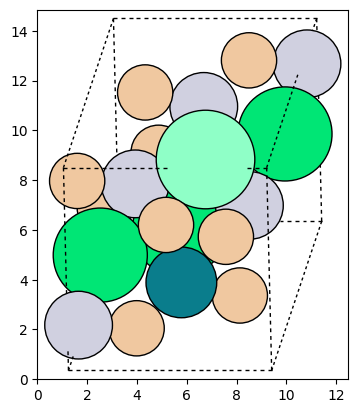

In [1]:
! git clone https://github.com/google-deepmind/materials_discovery.git
#@markdown Installation may require restarting the current colab kernel.
!pip install -q condacolab
import condacolab
condacolab.install()

!pip install vtk matplotlib x3d vapory pymatgen ase
!mamba install -c conda-forge nglview ipywidgets=7
from typing import Tuple

import os
import pandas as pd
import shutil
import tempfile
import zipfile

import pymatgen as mg
import pymatgen.io.cif

import ase.io.cif
import ase.visualize
import ase

# Enable custom widgets in colab
from google.colab import output
output.enable_custom_widget_manager()

PUBLIC_LINK = "https://storage.googleapis.com/"
BUCKET_NAME = "gdm_materials_discovery"

FOLDER_NAME = "gnome_data"
FILES = (
    "stable_materials_summary.csv",
    "by_reduced_formula.zip",
)

def download_from_link(link: str, output_dir: str):
  """Download a file from a public link using wget."""
  os.system(f"wget {link} -P {output_dir}")

parent_directory = os.path.join(PUBLIC_LINK, BUCKET_NAME)
for filename in FILES:
  public_link = os.path.join(parent_directory, FOLDER_NAME, filename)
  download_from_link(public_link, '.')

# Read the contents of the zipfile
# Due to the size of the release, this takes about 30 seconds but prevents
# the need to extract all files in order to read individual structures
z = zipfile.ZipFile('by_reduced_formula.zip')
# Parse the summary csv
gnome_crystals = pd.read_csv('stable_materials_summary.csv', index_col=0)
gnome_crystals
def obtain_structure(
    reduced_formula: str | None = None,
) -> Tuple[ase.Atoms, mg.core.Structure]:
  """Obtain the structure from a provided reduced formula."""
  temp_dir = tempfile.TemporaryDirectory()
  extension = f"{reduced_formula}.CIF"
  temp_path = os.path.join(temp_dir.name, extension)

  with z.open(os.path.join('by_reduced_formula', extension)) as zf:
    with open(temp_path, 'wb') as fp:
      shutil.copyfileobj(zf, fp)

  atoms = ase.io.read(temp_path)
  structure = mg.core.Structure.from_file(temp_path)
  temp_dir.cleanup()
  return atoms, structure


# @title Provide a reduced formula to select from the GNoME dataset.
# @markdown For a random structure, set the reduced formula to 'random' \
# @markdown Make sure to run this cell to select this select the formula.

reduced_formula = 'random' # @param {type:"string"}

if reduced_formula == 'random':
  sample = gnome_crystals.sample()
  reduced_formula = sample['Reduced Formula'].item()
else:
  # Ensure that composition entries are converted to reduced formulas
  reduced_formula = mg.core.Composition(reduced_formula).reduced_formula
  sample = gnome_crystals[
      gnome_crystals['Reduced Formula'] == reduced_formula].iloc[0:1]

atoms, structure = obtain_structure(reduced_formula)
sample
ase.visualize.view(atoms, viewer='x3d')
ase.visualize.view(atoms, viewer='ngl')

from ase.visualize.plot import plot_atoms
plot_atoms(atoms)

from google.colab import files
import tempfile
import os
from tempfile import mkstemp

fmt = "cif" #@param ['cif', 'poscar', 'cssr', 'json', 'yaml', 'yml', 'xsf', 'mcsqs', 'res', 'pwmat']
temp_dir = tempfile.TemporaryDirectory()
filename = os.path.join(temp_dir.name, f"{structure.reduced_formula}.{fmt}")
structure.to(filename, fmt=fmt)
files.download(filename)
temp_dir.cleanup()